# Parallel OSDT

In [ ]:
# All dependencies of this notebook

# third-party imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.tree import DecisionTreeClassifier

# local imports
from lib.parallel_osdt_classifier import ParallelOSDTClassifier
from lib.model_selection import train_cross_validate
from lib.data_processing import read_dataset

# Using COMPAS as an example
dataset = read_dataset('data/preprocessed/compas-binary.csv', sep=";") 
(n, _m) = dataset.shape
X = dataset.values[:n,:-1]
y = dataset.values[:n,-1]

hyperparameters = {
    'regularization': 0.005, # Regularization coefficient which effects the penalty on model complexity

    'max_depth': float('Inf'), # User-specified limit on the model
    'max_time': float('Inf'), # User-specified limit on the runtime 

    'clients': 1, # Parameter that varies based on how much computational resource is available
    'servers': 1, # Parameter that varies based on how much computational resource is available

    'visualize': False, # Toggle whether a rule-list visualization is rendered
    'verbose': False, # Toggle whether event messages are printed
    'log': False, # Toggle whether client processes log to logs/work_<id>.log files
    
    'configuration': { # More configurations around toggling optimizations and prioritization options
            'priority_metric': 'uniform', # Decides how tasks are prioritized
            'deprioritization': 0.1, # Decides how much to push back a task if it has pending dependencies

            # Note that Leaf Permutation Bound (Theorem 6) is 
            # Toggles the assumption about objective independence when composing subtrees (Theorem 1)
            # Disabling this actually breaks convergence due to information loss
            'hierarchical_lowerbound': True, 
            # Toggles whether problems are pruned based on insufficient accuracy (compared to other results) (Lemma 2)
            'look_ahead': True,
            # Toggles whether a split is avoided based on insufficient support (proxy for accuracy gain) (Theorem 3)
            'support_lowerbound': True,
            # Toggles whether a split is avoided based on insufficient potential accuracy gain (Theorem 4)
            'incremental_accuracy_lowerbound': True,
            # Toggles whether a problem is pruned based on insufficient accuracy (in general) (Theorem 5)
            'accuracy_lowerbound': True,
            # Toggles whether problem equivalence is based solely on the capture set (Similar to Corollary 6)
            'capture_equivalence': True,
            # Hamming distance used to propagate bounding information of similar problems (Theorem 7 + some more...)
            "similarity_threshold": 0,
            # Toggles whether equivalent points contribute to the lowerbound (Proposition 8 and Theorem 9)
            'equivalent_point_lowerbound': True,

            # Toggles compression of dataset based on equivalent point aggregation
            'equivalent_point_compression': True,
            # Toggles whether asynchronous tasks can be cancelled after being issued
            'task_cancellation': True,
            # Toggles whether look_ahead prunes using objective upperbounds (This builds on top of look_ahead)
            'interval_look_ahead': True,
            # Cooldown timer (seconds) on synchornization operations
            'synchronization_cooldown': 0.1
    }
}

start = time()

model = ParallelOSDTClassifier(**hyperparameters)
model.fit(X, y)
prediction = model.predict(X)
# print('Prediction {}'.format(prediction))
training_accuracy = model.score(X, y)

print("Runtime: {} seconds".format(time() - start))
print('Training Accuracy {}'.format(training_accuracy))


# Sequential OSDT

In [ ]:
# All dependencies of this notebook

# third-party imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# local imports
from lib.osdt_classifier import OSDTClassifier
from lib.model_selection import train_cross_validate
from lib.data_processing import read_dataset

# Using COMPAS as an example
dataset = read_dataset('data/preprocessed/compas-binary.csv', sep=";") 
(n, _m) = dataset.shape
X = dataset.values[:,:-1]
y = dataset.values[:,-1]

hyperparameters = {
    'regularization': 0.005, # Regularization coefficient which effects the penalty on model complexity
    'max_depth': float('Inf'), # User-specified limit on the model
    'max_time': float('Inf'), # User-specified limit on the runtime 
    
    'log': False, # Toggle logging
    
    'configuration': { # More configurations around toggling optimizations and prioritization options
            'priority_metric': 'curiosity', # Decides how tasks are prioritized
            # Note that Leaf Permutation Bound (Theorem 6) is 
            # Toggles whether problems are pruned based on insufficient accuracy (compared to other results) (Lemma 2)
            'look_ahead': True,
            # Toggles whether a split is avoided based on insufficient support (proxy for accuracy gain) (Theorem 3)
            'support_lowerbound': True,
            # Toggles whether a split is avoided based on insufficient potential accuracy gain (Theorem 4)
            'incremental_accuracy_lowerbound': True,
            # Toggles whether a problem is pruned based on insufficient accuracy (in general) (Theorem 5)
            'accuracy_lowerbound': True,
            # Toggles whether equivalent points contribute to the lowerbound (Proposition 8 and Theorem 9)
            'equivalent_point_lowerbound': True,
    }
}

model = OSDTClassifier(**hyperparameters)
model.fit(X, y)
prediction = model.predict(X)
print('Prediction {}'.format(prediction))
training_accuracy = model.score(X, y)
print('Training Accuracy {}'.format(training_accuracy))

In [ ]:
# datasets = [ # Times: M, N, Sequential vs 60-core, Speed-up
#     'balance-scale', # 16, 625, NA, NA, NA
#     'car-evaluation', # 15, 1728, NA, NA, NA
#     'compas-binary',  # 12, 6907, 17.575s vs 4.277s, 4.10
#     'fico_binary', # 17, 10459, NA, NA, NA
#     'monk1-train', # 11, 124, 229.702s vs 62.187s, 3.69
#     'monk2-train', # 11, 169, NA, NA, NA
#     'monk3-train', # 11, 122, NA, NA, NA
#     'tic-tac-toe' # 18, 958, NA, NA, NA
# ]

import cProfile
import numpy as np
from time import time

from lib.data_processing import read_dataset
from lib.parallel_osdt import ParallelOSDT
file_name = 'data/preprocessed/compas-binary.csv' # Expect 8 seconds
# file_name = 'data/preprocessed/monk3-train.csv' # Expect 40 seconds
# file_name = 'data/preprocessed/fico_binary.csv' # Expect NA seconds
# file_name = 'data/preprocessed/tic-tac-toe.csv' # Expect NA seconds
# file_name = 'tests/fixtures/identity.csv'
# file_name = 'tests/fixtures/split.csv'
dataset = read_dataset(file_name, sep=';')
(N,M) = dataset.shape
n = N
X = dataset.values[:n, :-1]
y = dataset.values[:n, -1]
lamb = 0.005
print(X.shape)
print(X)
print(y)

start = time()
problem = ParallelOSDT(X, y, lamb, max_time=300)
print("\nRunning OSDT on {}".format(file_name))
# cProfile.run('problem.solve(clients=1, servers=1, visualize=True)', sort='tottime')
model = problem.solve(clients=1, servers=1, visualize=True)

In [ ]:
from lib.data_processing import read_dataset

codes = [
    '2_0_0',
    '2_0_1',
    '2_1_0',
    '2_1_1',
    '2_2_0',
    '2_2_1',
    '2_3_0',
    '2_3_1',
    '2_4_0',
    '2_4_1',
    '3_0_0',
    '3_0_1',
    '3_1_0',
    '3_1_1',
    '3_2_0',
    '3_2_1',
    '3_3_0',
    '3_3_1',
    '3_4_0',
    '3_4_1',
    '22_0_0',
    '22_0_1',
    '22_1_1',
    '22_2_0',
    '22_2_1',
    '22_3_0',
    '22_3_1',
    '22_4_0',
    '22_4_1',
    '24_0_0',
    '24_0_1',
    '24_1_1',
    '24_2_0',
    '24_2_1',
    '24_3_0',
    '24_3_1',
    '24_4_0',
    '24_4_1',
    '26_0_0',
    '26_0_1',
    '26_1_1',
    '26_2_0',
    '26_2_1',
    '26_3_0',
    '26_3_1',
    '26_4_0',
    '26_4_1',
    '28_0_0',
    '28_0_1',
    '28_1_1',
    '28_2_0',
    '28_2_1',
    '28_3_0',
    '28_3_1',
    '28_4_0',
    '28_4_1'
]

shapes = {}
for code in codes:
    file_name = 'data/census-data/20181224/census_c1s5ky0.{}_test.csv'.format(code) # 2500, 332
    dataset = read_dataset(file_name, sep=',')
    shapes[file_name] = dataset.shape
    print(file_name, dataset)
    file_name = 'data/census-data/20181224/census_c1s5ky0.{}_train.csv'.format(code) # 2500, 332
    dataset = read_dataset(file_name, sep=',')
    shapes[file_name] = dataset.shape
    print(file_name, dataset)
    

for filename, shape in shapes.items():
    print(filename, shape)

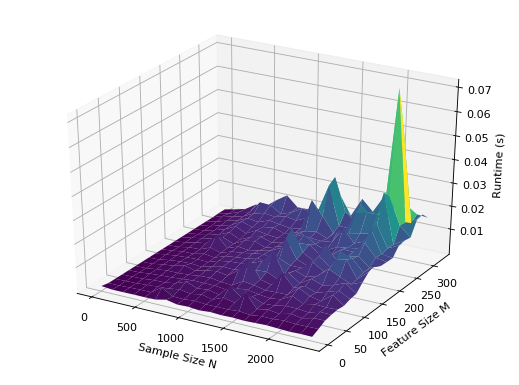

In [3]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

from lib.data_processing import read_dataset
from lib.analysis import plot_scalability_analysis

dataset = read_dataset('data/scalability/cart_census.csv', ',')
plot_scalability_analysis(dataset)